# Detecting Sentence Relevance Using A Custom NLP Model

Determining the relevance of a sentence within a specific document is essential for many applications in the healthcare and life sciences field. 

For example, at the end of each patient visit, physicians will often write a short statement to summarize their notes regarding that visit. Over time, these short summary statements begin to take form  as important datapoints that explain the patient's medical history. Future physicians may rely on those summary statements to quickly get a gist of the medical conditions and history of that patient. Thus the cost of error in these summaries is high and has the potential to negatively affect the patient's care overall. 

The approach that we will be deploying in this notebook will aid in situations like this by automatically determining the relevance of each summary statement in regards to the supporting notes or documentation that it is summarizing. We will deploy this approach using BERT word embeddings to discover which statements within the supporting documentation are most similar to the summary statement associated.

If you are using SageMaker Studio, please use the `Python 3 (Data Science)` kernel. If you are using a SageMaker Notebook Instance, please use the `conda_python3` kernel.


We will be using this notebook to do the following:
- Write a custom NLP model using BERT
- Create a Flask application that can query our model
- Create a Docker image of our Flask application 
- Push our Docker image to Amazon's Elastic Container Registry (ECR)
- Create and configure our own Elastic Container Service (ECS) and use our Docker image to deploy our application 

The solution that we will implement will have this architecture:


In [ ]:
! pip install botocore==1.18.16 sentence-transformers==0.3.7.2 pandas==1.0.1 s3fs==0.5.1 numpy==1.18.1 sagemaker-studio-image-build==0.3.1
#!conda update --all -y
#!sh ./install_packages.sh #Run installation from shell if pip fails

In [ ]:
%%writefile model_scripts/hosted_model.py

from sentence_transformers import models, losses
from sentence_transformers import SentencesDataset, LoggingHandler, SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import *
import json
from scipy.stats import gaussian_kde
import nltk
import scipy
import numpy
import nltk
nltk.download('punkt')

#configure logging
import logging 
logger = logging.getLogger('log')
logger.setLevel(logging.INFO)

class MedicalBertModel():
    def __init__(self,run_null_model=None):
        self.run_null_model=run_null_model
        pass
    
    def run_null(self,null_location='null_hypothesis.txt',score=None):
        '''run null hypothesis to get pvalue'''
        f_in=open(null_location,'r')
        hist_dists_null=json.load(f_in)
        #next, create the kernel density estimation (kde) for the null hypothesis
        kde= gaussian_kde(hist_dists_null)
        pvalue=self.get_pvalue(kde,score)
        return(pvalue)

    def get_pvalue(self,kde,score):
        '''given kde of the null hypothesis, get the probability of achieving that score or better'''
        logger.debug(score)
        pvalue=kde.integrate_box_1d(0,score)
        return(pvalue)

    def break_up_by_sentence(self,the_string):
        '''break up supporting documentation into separate sentences'''
        to_return=nltk.tokenize.sent_tokenize(the_string)
        return(to_return)

    def get_best_n_sentences(self,corpus,distances,max_to_return=5):
        '''get the top n closest sentences; where lower distance is better'''
        max_to_return=5
        if len(corpus) <5: #
            max_to_return=len(corpus) 
        the_indices=numpy.argsort(distances)
        top_n_indices=the_indices[0:max_to_return]
        top_n_dist=[distances[i] for i in top_n_indices]
        logger.debug(corpus)
        top_n_corpus=[corpus[i] for i in top_n_indices]
        top_n_pvalues=[]
        if self.run_null_model==True:
            for i in range(0,len(top_n_dist)):
                temp_result=self.run_null(score=top_n_dist[i])
                top_n_pvalues.append(temp_result)	
        list_to_return=[]
        for i in range(0,len(top_n_indices)):
            if self.run_null_model==True:
                the_dict={"rank":i+1,"matching_sentence":top_n_corpus[i],"pvalue":top_n_pvalues[i],"distance":top_n_dist[i]}
            else:
                the_dict={"rank":i+1,"matching_sentence":top_n_corpus[i],"distance":top_n_dist[i]}
            list_to_return.append(the_dict)
        return(list_to_return)
    
    def run_model_and_null(self,request):
        '''run model and null model if specified'''
        request_dict=json.loads(request)
        input_sentence=request_dict['input_sentence']
        the_paragraph=request_dict['input_paragraph']
        model_result=self.run_model(input_sentence,the_paragraph)
        return(model_result)
    
    def run_model(self,input_sentence,the_paragraph):
        #get the embedder
        word_embedding_model = models.Transformer('emilyalsentzer/Bio_ClinicalBERT')
        # Apply mean pooling to get one fixed sized sentence vector
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                   pooling_mode_mean_tokens=True,
                                   pooling_mode_cls_token=False,
                                   pooling_mode_max_tokens=False)
        embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
        # create a corpus of every individual sentence within the paragraph
        corpus=self.break_up_by_sentence(the_paragraph)
        corpus_embeddings = embedder.encode(corpus)
        # define the input sentence as the query
        queries = [input_sentence]
        query_embedding = embedder.encode(queries)
        # calculate the distance between the query embedding and the corpus embeddings
        distances = scipy.spatial.distance.cdist(query_embedding, corpus_embeddings, "cosine")[0]
        to_return=self.get_best_n_sentences(corpus,distances)
        return(to_return)


if __name__=='__main__':
    mbm=MedicalBertModel(run_null_model=False)
    mock_input=json.dumps({'input_sentence':'The patient is healthy.',"input_paragraph":"The patient's health is good. The patient does not have a fever. The patient is a 28 year old female."})
    result=mbm.run_model_and_null(mock_input)
    logger.info(f'Model result: {result}')




# Test Model Performance Locally
Generally, you will want to test the model's performance before performing. We will do a short test using the MTSamples data. The original dataset is from  [MTSamples](https://www.mtsamples.com/). We downloaded the data used from that cite and stored on [Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions).

Let us first load the data, and we will analyze it later.

In [3]:
#define handy functions
import pandas
import nltk
import numpy
import json
import sys;sys.path.append('model_scripts') #so that notebook can see models
import matplotlib.pyplot as plt
from hosted_model import MedicalBertModel

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
!mkdir data
!aws --no-sign-request s3 cp s3://aws-hcls-ml/mtsamples/mtsamples.csv data/mtsamples.csv
df_0=pandas.read_csv('data/mtsamples.csv', engine='python')

download: s3://aws-hcls-ml/mtsamples/mtsamples.csv to data/mtsamples.csv


In [5]:
#remove descriptions that are short
df_0['des_word_count']=df_0.apply(lambda x : len(x['description'].strip().split(" ")),axis=1)
df_0['trans_word_count']=df_0.apply(lambda x : len(str(x['transcription']).split(" ")),axis=1)
df_1=df_0[df_0['des_word_count']>=10]
df_1=df_1[df_1['trans_word_count']>=100]
df_1.shape
df_1=df_1.sample(100)
df_1=df_1.reset_index(drop=True)
df_1.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,des_word_count,trans_word_count
0,137,"Some improvement of erectile dysfunction, on ...",Urology,Erectile Dysfunction - Followup,"HISTORY OF PRESENT ILLNESS: , The patient pres...","urology, improvement of erectile dysfunction, ...",14,356
1,1459,This is a 43-year-old female with a history o...,Sleep Medicine,Video EEG,"TIME SEEN: , 0734 hours and 1034 hours.,TOTAL ...","sleep medicine, electroencephalography, eeg mo...",25,160
2,149,"Exploratory laparotomy, resection of small bo...",Urology,Cystoprostatectomy,"PREOPERATIVE DIAGNOSES:,1. Clinical stage T2,...",,51,2096
3,3035,Right-sided abdominal pain with nausea and fe...,Nephrology,CT Abdomen & Pelvis - 6,"REASON FOR EXAM: , Right-sided abdominal pain ...","nephrology, adrenal glands, appendicitis, gall...",33,120
4,1549,Myocardial perfusion imaging - patient with h...,Radiology,Myocardial Perfusion Imaging - 1,"MEDICATIONS: , Plavix, atenolol, Lipitor, and ...","radiology, myocardial perfusion imaging, bruce...",14,370


Before explaining the test we will perform, let's first discuss the data. MTSamples contains many different sample medical transcriptions across different specialities. You can read more about the data at [MTSamples](https://www.mtsamples.com/). 

Amongst other fields, you can see from the loaded data that there is a field called `description` and a field called `transcription`. THe transcription is the full sample transcript; the `description` is a concise summary of the transcript. It may either be a summary, a brief restatement of the symptoms or a brief description of the operation performed. 

One way that we can test whether the BERT embedding works well is by doing the following analysis: 

Take 100 pairs of description/transcription pairs and compute the *minimum* distance between the description and each sentence within the transcript. This will produce a distribution of distances. Some distances will be lower (remember, lower means closer!) and others will be higher. Those distances that are lower mean that a particular description had a sentence within the transcript that is a close match to it!

We will also create another *scrambled dataset*. This is a selection of 100 descriptions/transcripts pairs where we have scrambled the matching between the description/transcript. Thus, in this new mock dataset, each description is *not* matched to its corresponding transcript. It is instead matched to a random transcript. 

What are the expected results of the experiment? We would anticipate that if the embedding model captures the content of the sentence well that overall the scores of the true dataset should be **lower** that that found for the random dataset. This is because a description is, on average, expected to have a *closer distance to its corresponding transcript than to a random transcript*.

In [6]:
#Create a random scramble of the data to see how well the embedder works
df_rand=df_1.copy(deep=True)
df_rand['description'] = numpy.random.permutation(df_1['description'].values)
df_rand=df_rand.reset_index(drop=True)

Next scramble the data and run the model on actual and scrambled data. This will take about 15 minutes in total

In [7]:
hist_dists=[]
mdm=MedicalBertModel(run_null_model=False)
for i in range(0,df_1.shape[0]):
    the_paragraph=df_1.at[i,'transcription']
    input_sentence=df_1.at[i,'description']
    the_input=json.dumps({'input_sentence':input_sentence,"input_paragraph":the_paragraph})
    result=mdm.run_model_and_null(the_input)
    best_result=result[0]['distance'] #sentence that best matches
    hist_dists.append(best_result)
    if i%10==0:
        print("Up to iteration "+str(i))
print ('Done creating random sample of actual data.')


Up to iteration 0
Up to iteration 10
Up to iteration 20
Up to iteration 30
Up to iteration 40
Up to iteration 50
Up to iteration 60
Up to iteration 70
Up to iteration 80
Up to iteration 90
Done creating random sample of actual data.


In [8]:
hist_dists_rand=[]
mdm=MedicalBertModel(run_null_model=False)
for i in range(0,df_rand.shape[0]):
    the_paragraph=df_rand.at[i,'transcription']
    input_sentence=df_rand.at[i,'description']
    the_input=json.dumps({'input_sentence':input_sentence,"input_paragraph":the_paragraph})
    result=mdm.run_model_and_null(the_input)
    best_result=result[0]['distance'] #sentence that best matches
    hist_dists_rand.append(best_result)
    if i%10==0:
        print("Up to iteration "+str(i))
print('Done creating random sample of scrambled data.')

Up to iteration 0
Up to iteration 10
Up to iteration 20
Up to iteration 30
Up to iteration 40
Up to iteration 50
Up to iteration 60
Up to iteration 70
Up to iteration 80
Up to iteration 90
Done creating random sample of scrambled data.


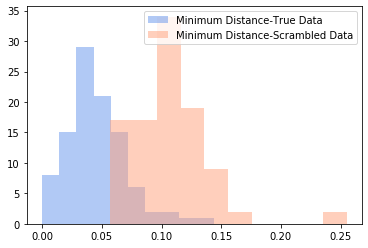

In [9]:
plt.hist(hist_dists ,alpha=0.5, color='cornflowerblue', label='Minimum Distance-True Data')
plt.hist(hist_dists_rand,alpha=0.5, color='lightsalmon', label='Minimum Distance-Scrambled Data')
plt.legend(loc='upper right')
plt.show()

As you can see from the histogram the minimum distances found between a random sample of true description-transcription pairs (blue) is much closer than on average than the minimum distance of a random sample of scrambling of description-transcription pairs. This gives evidence that the model meaninfully picks up true relationships between the description and transcription.

# Creating a Flask application to query our model

We will be deploying the model to ECS using Flask. To do this we need to create a Flask application that can query the model. The "transformation" function defined below will perform queries to the model. The code in the following sections is modified from [here](https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/scikit_bring_your_own/container/decision_trees).

In [ ]:
%%writefile model_scripts/predictor.py
import flask
import json
import os
from hosted_model import MedicalBertModel
import logging

# The flask app for serving predictions
app = flask.Flask(__name__)

@app.route('/ping', methods=['GET'])
def ping():
    """Determine if the container is working and healthy. In this sample container, we will declare
    it healthy if we can load the model successfully."""
    health = ScoringService.get_model() is not None  # You can insert a health check here
    status = 200 if health else 404
    return flask.Response(response='\n', status=status, mimetype='application/json')

@app.route('/invocations', methods=['POST'])
def transformation():
    """ this specifies the transformation that will be performed with the raw data from the moment the request was receieved to the moment the response was returned"""
    data = None
    #get input data from flask request
    data = flask.request.data.decode('utf-8')
    logging.debug(f"raw data supplied: {data}")
    #instantiate the MedicalBertModel class
    mbm=MedicalBertModel(run_null_model=False)
    #run model
    result=mbm.run_model_and_null(data)
    result=json.dumps(result)
    logging.debug(f"result of model: {result}")
    return flask.Response(response=result, status=200)


# Writing the Serve Code
Now we will write the `serve` code that will serve the model. We will be using [Nginx](https://docs.nginx.com/nginx/) as the front end web server, while [Gunicorn](https://gunicorn.org/) will be used to serve the Flask App.

In [ ]:
%%writefile model_scripts/serve
#!/usr/bin/env python

# This file implements the scoring service shell. You don't necessarily need to modify it for various
# algorithms. It starts nginx and gunicorn with the correct configurations and then simply waits until
# gunicorn exits.
#
# The flask server is specified to be the app object in wsgi.py
#
# We set the following parameters:
#
# Parameter                Environment Variable              Default Value
# ---------                --------------------              -------------
# number of workers        MODEL_SERVER_WORKERS              the number of CPU cores
# timeout                  MODEL_SERVER_TIMEOUT              300 seconds

from __future__ import print_function
import multiprocessing
import os
import signal
import subprocess
import sys
import logging
logging.getLogger().setLevel(logging.DEBUG)

cpu_count = multiprocessing.cpu_count()

model_server_timeout=300
model_server_workers = int(os.environ.get('MODEL_SERVER_WORKERS', cpu_count))

def sigterm_handler(nginx_pid, gunicorn_pid):
    '''Used to kill the process if necessary'''
    logging.debug('hello from sigterm_handler')
    try:
        os.kill(nginx_pid, signal.SIGQUIT)
    except OSError:
        pass
    try:
        os.kill(gunicorn_pid, signal.SIGTERM)
    except OSError:
        pass

    sys.exit(0)

    
def start_server():
    logging.debug('hello from start_server')
    print('Starting the inference server with {} workers.'.format(model_server_workers))

    # link the log streams to stdout/err so they will be logged to the container logs
    subprocess.check_call(['ln', '-sf', '/dev/stdout', '/var/log/nginx/access.log'])
    subprocess.check_call(['ln', '-sf', '/dev/stderr', '/var/log/nginx/error.log'])
    
    nginx = subprocess.Popen(['nginx', '-c', '/opt/program/nginx.conf'])
    gunicorn = subprocess.Popen(['gunicorn',
                                 '--timeout', str(model_server_timeout),
                                 '-k', 'gevent',
                                 '-b', 'unix:/tmp/gunicorn.sock',
                                 '-w', str(model_server_workers),
                                 'wsgi:app'])

    signal.signal(signal.SIGTERM, lambda a, b: sigterm_handler(nginx.pid, gunicorn.pid))

    # If either subprocess exits, so do we.
    pids = set([nginx.pid, gunicorn.pid])
    while True:
        pid, _ = os.wait()
        if pid in pids:
            break

    sigterm_handler(nginx.pid, gunicorn.pid)
    print('Inference server exiting')

    
# The main routine just invokes the start_server function.
if __name__ == '__main__':
    start_server()
    logging.debug('starting server')


NOTE: There are other scripts that we will be using that configure Nginx and Flask for serving the model located in the `model_scripts` directory. You can manually inspect them if you wish in the `model_scripts` directory.


# Creating a Dockerfile

At this point we have created our model and the flask application that will be used to serve our model. Next, we need to create the Dockerfile that will contain a list of instructions to inform Docker on how our Docker image should be built and what should be included in our Docker container (e.g. our model and application).

In [ ]:
%%writefile Dockerfile
# Build an image that can do inference
# This is a Python 3 image that uses the nginx, gunicorn, flask stack
# for serving inferences in a stable way.
 
FROM ubuntu:16.04
#FROM public.ecr.aws/ubuntu/ubuntu:18.04_stable

MAINTAINER Amazon AI <sage-learner@amazon.com>
# Install python and other s dependencies
# Dependency list from http://scikit-learn.org/stable/developers/advanced_installation.html#installing-build-dependencies
RUN apt-get update && \
    apt-get -y install \
        build-essential \
        libatlas-dev \
        git \
        wget \
        curl \
        nginx \
        jq \
        libatlas3-base \
        openjdk-8-jdk-headless

RUN curl -LO http://repo.continuum.io/miniconda/Miniconda3-py38_4.9.2-Linux-x86_64.sh && \
    bash Miniconda3-py38_4.9.2-Linux-x86_64.sh -bfp miniconda3 && \
    rm Miniconda3-py38_4.9.2-Linux-x86_64.sh

ENV PATH=/miniconda3/bin:${PATH}

# Set some environment variables. PYTHONUNBUFFERED keeps Python from buffering our standard
# output stream, which means that logs can be delivered to the user quickly. PYTHONDONTWRITEBYTECODE
# keeps Python from writing the .pyc files which are unnecessary in this case. We also update
# PATH so that the train and serve programs are found when the container is invoked.

ENV PYTHONUNBUFFERED=TRUE
ENV PYTHONDONTWRITEBYTECODE=TRUE
ENV PATH="/opt/program:${PATH}"

#use python 3.7.6
RUN conda install python=3.7.6


RUN python -m pip install --no-cache -I numpy==1.18.1
RUN python -m pip install --no-cache -I scipy==1.4.1
RUN python -m pip install --no-cache -I sentence-transformers==0.3.5.1
RUN python -m pip install --no-cache -I json5==0.9.1
RUN python -m pip install --no-cache -I nltk==3.4.5
RUN python -m pip install --no-cache -I Flask==1.1.1
RUN python -m pip install --no-cache -I gunicorn==20.0.4

#Note that the specific version of genvent/greenlet needed may change over time
#RUN python -m pip install --no-cache -I gevent==1.4.0
#RUN python -m pip install --no-cache -I gevent==20.6.2 
RUN python -m pip install --no-cache -I gevent==20.9.0
RUN python -m pip install --no-cache -I pandas==0.25.3
#RUN python -m pip install --no-cache -I greenlet==0.4.15
RUN python -m pip install --no-cache -I greenlet==0.4.17


# Set up the program in the image
COPY model_scripts /opt/program 

WORKDIR /opt/program
#Download needed data for hosting
RUN python download_embedding_data.py
CMD serve

# Pushing the Dockerfile to Amazon Elastic Container Registry (ECR)

Now that we have created our Dockerfile, we need to push it to Amazon's Elastic Container Registry (ECR). This will take about 5 minutes to complete and will generate a lot of output. We will be using [AWS CodeBuild](https://aws.amazon.com/codebuild/) to build the application. Before using AWS CodeBuild, please make sure that the role you are using has permission to use CodeBuild], as explained [here](https://github.com/aws-samples/sagemaker-studio-image-build-cli).

NOTE: edit the IAM policy to specify which ECR repo you are trying to push the image to if you wish to create a different repo.

## Note
If you receive an error `toomanyrequests: You have reached your pull rate limit. You may increase the limit by authenticating and upgrading: https://www.docker.com/increase-rate-limit` or a similair error, you are likely reaching [Docker Hub's rate limits](https://docs.docker.com/docker-hub/download-rate-limit/) at the time of running `sm-docker`. Please see [increase-rate-limits](https://www.docker.com/increase-rate-limits) and [Advice for customers dealing with Docker Hub rate limits, and a Coming Soon announcement](https://aws.amazon.com/blogs/containers/advice-for-customers-dealing-with-docker-hub-rate-limits-and-a-coming-soon-announcement/) for more information.

In [ ]:
#!sh ./build_and_push_docker.sh sentence_relevence_matcher v1 #you can use this if docker is locally installed
!sm-docker build . --repository sentence_relevence_matcher:v1


# Create the ECS Container

First, log into the AWS Console and navigate to the ECS page. If you click on the "Clusters" tab on the left, you will notice that there's a cluster named "My-Container-Cluster". This cluster was created when we ran the CloudFormation template in the beginning. That being said, now we need to create a task. A task allows you to define a set of containers that you would like to be placed together (or part of the same placement decision), their properties, and how they may be linked. For our purposes, we will only need to include the one container that we've created during this workshop. Follow the steps below to do so.
   

## 1. Select the "Task Definitions" tab on the sidebar
## 2. Select "Create new task definition"
<br></br>

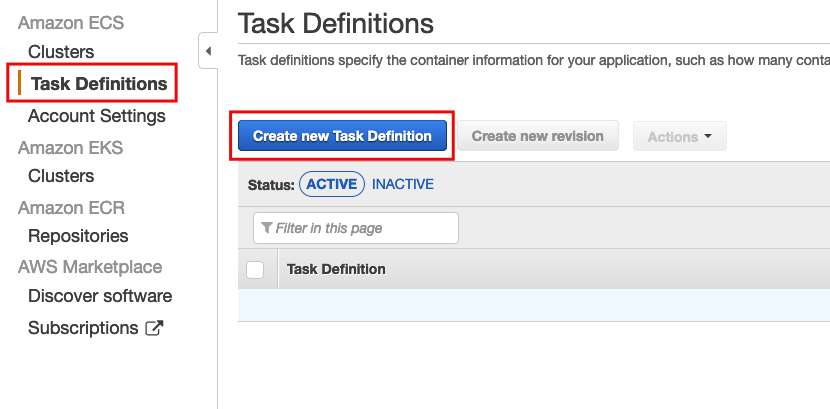

## 3. Select "Fargate" as your launch type compatibility and then select "Next step" 

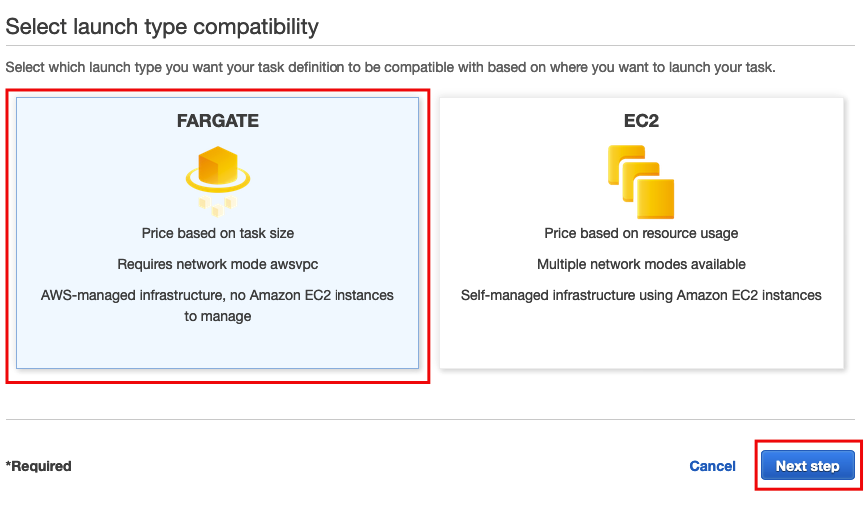

## 4. Enter "sentence_relevance_task" as the Task Definition Name
## 5. For role, select "EcsTaskExecutionRole"  
If you do not see this role, select `Create new role`.
## 6. For Network Mode, confirm that "awsvpc" is selected   
## 7. For Task Execution IAM role, select "ecsTaskExecutionRole"

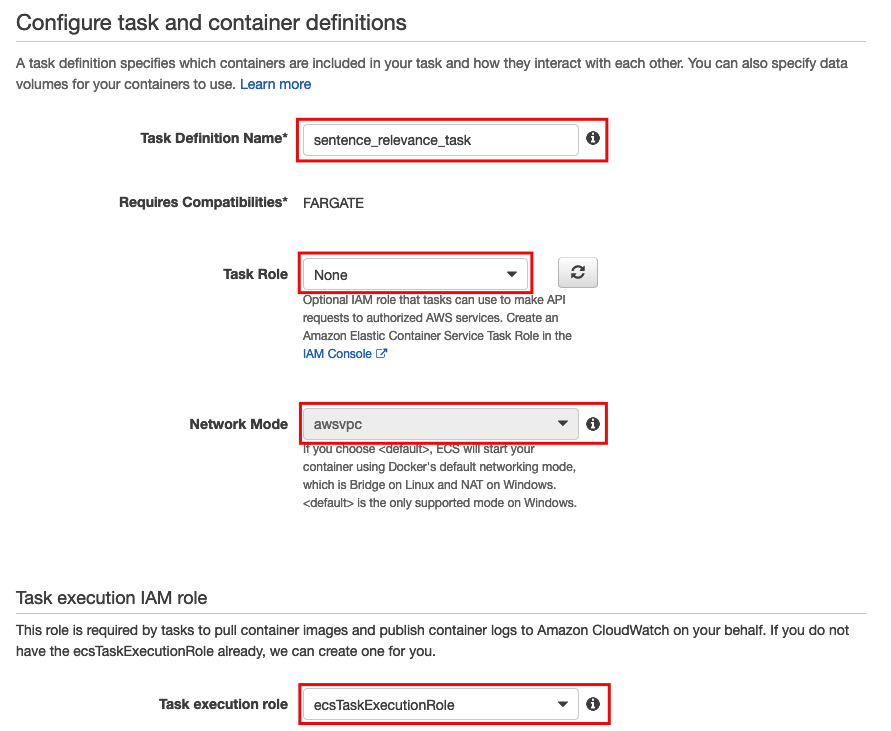


## 8. For Task memory, select "2 GB" and for Task CPU "1 vCPU"
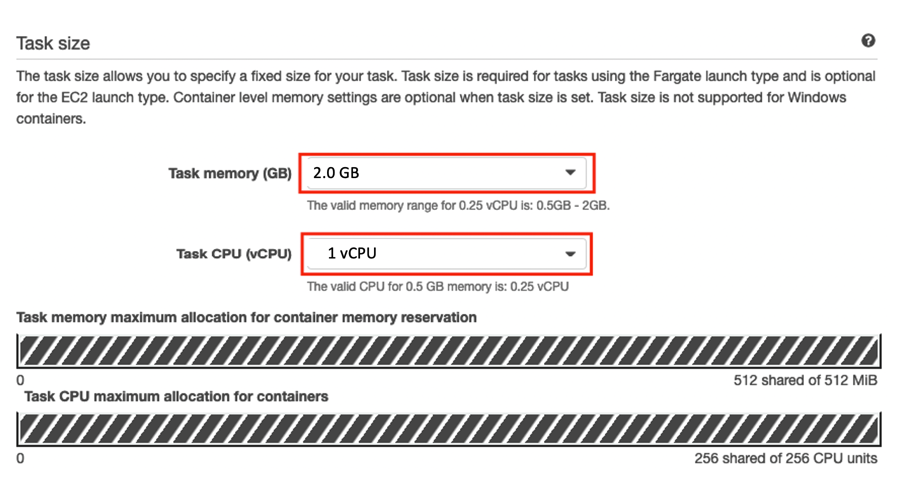

## 9. Then, Select "Add Container"
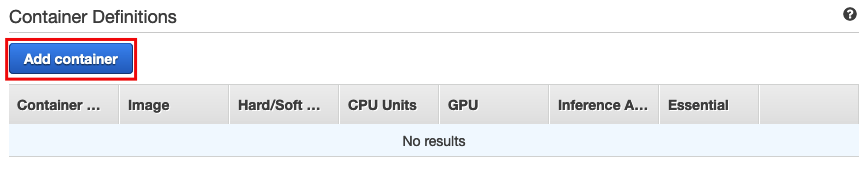

### 9a. For container name, call it "sentence_relevance_task"

### 9b. For the Image, we use the container created. Find it here: https://console.aws.amazon.com/ecr/repositories/ 

Make sure that the container link you use includes the version, in our case, `v1`. The URI was also printed above when the docker container was pushed. It looks something like this: `xxxxxxxxxxxx.dkr.ecr.us-east-1.amazonaws.com/sentence_relevence_matcher:v1`

### 9c. For "Port mappings enter "80" 

### 9d. Leave everything else with default values

### 9e. Click "Add"
<br></br>

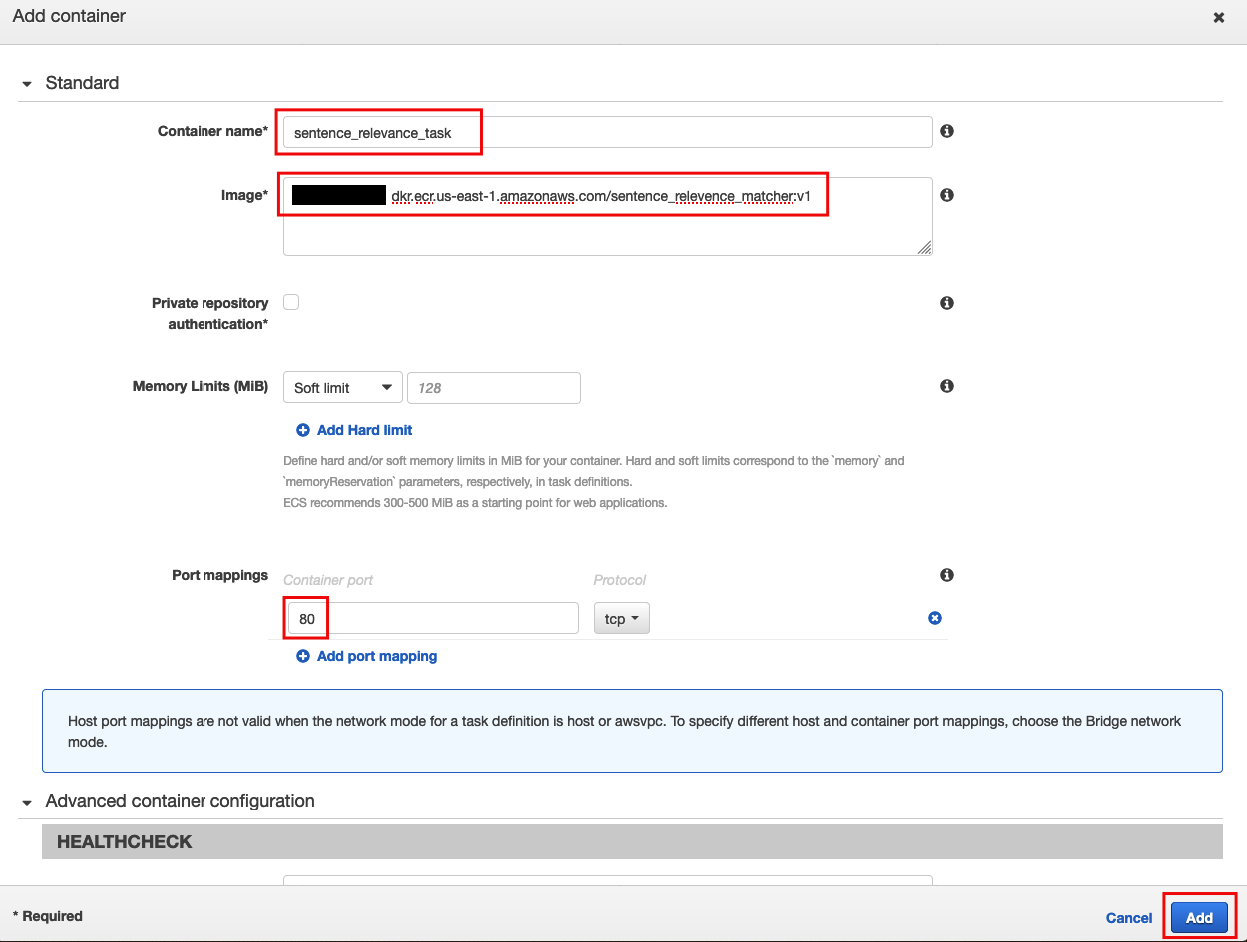

## 10. Scroll to the bottom and select "Create"

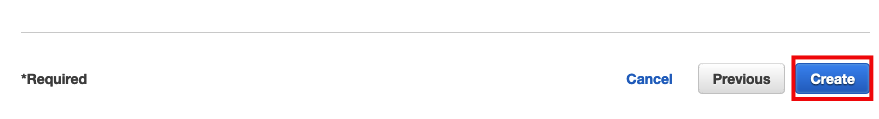

NOTE: For the purposes of this workshop, we will be deploying the model to a public subnet and assigning it a public IP address. This model is therefore accessible to anyone with an internet connection. In production, you should deploy your model to a private subnet. 

# Deploy the Container 

Now that we've created the task definition, we need to actually deploy the container. Follow the steps below to do so.

### 1. Now go back to the main ECS Page (you can do this by clicking `View Task Definition` in the bottom right hand corner), by selecting "Clusters" on the sidebar
### 2. Select "My-Container-Cluster". This container cluster was created when you ran the Cloud Formation Template.
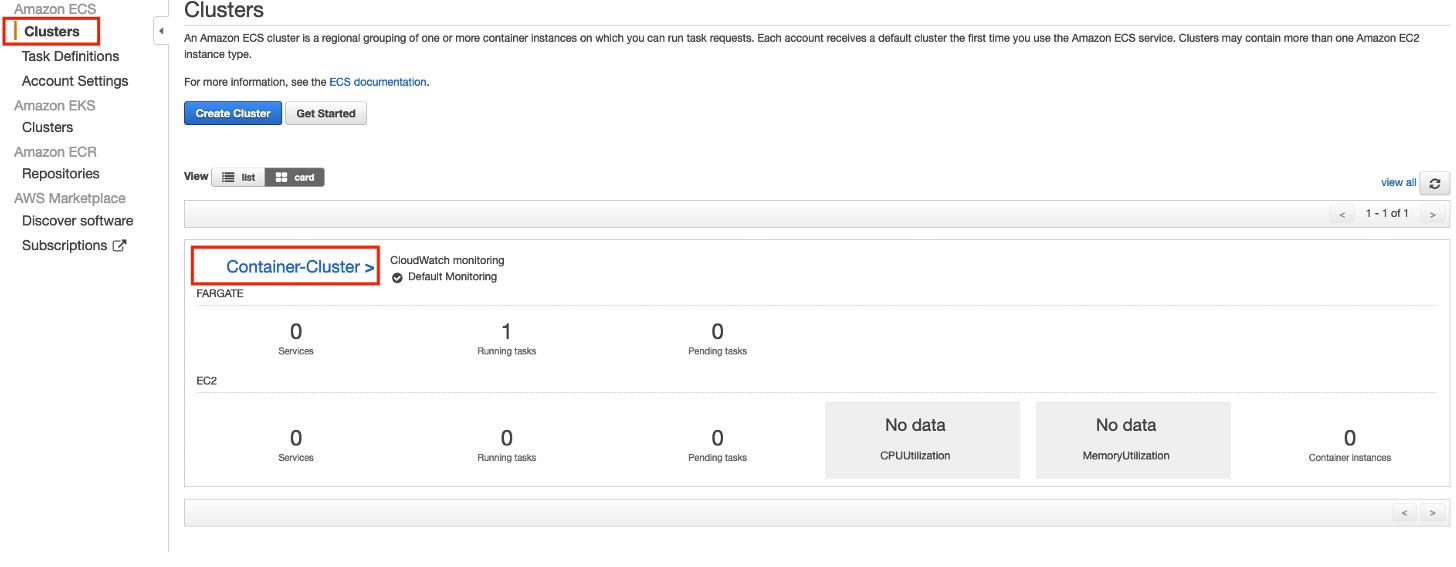



### 3. Then select the "Tasks" tab 
### 4. Click "Run new Task"
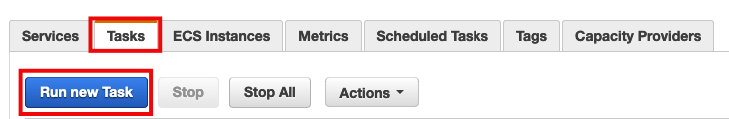


### 5. For launch type, click "Fargate"
### 6. For "Task Definition" select "sentence_relevance_task"    
### 7. For VPC, select your VPC
### 8. For Subnet launch in the **Public Subnet**
### 9. Select "ENABLED" for auto-assign public IP
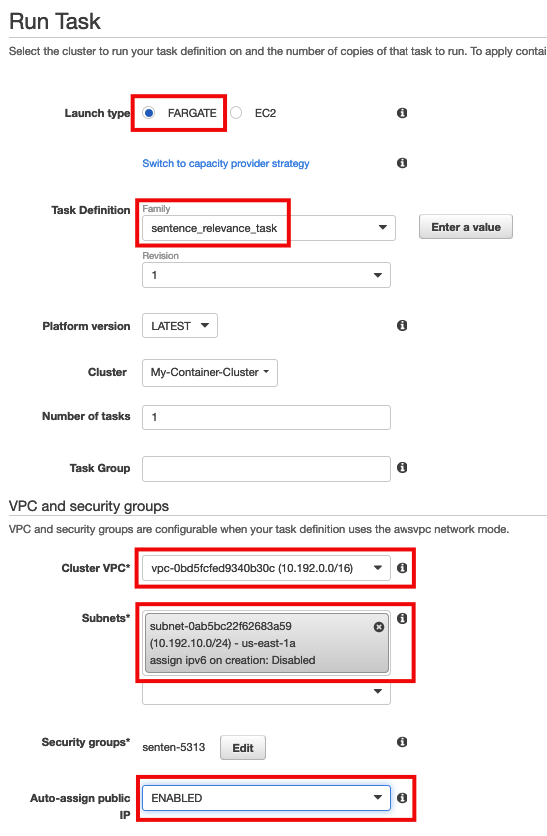


### 10. Click `Run Task` to start the task. When the container is deployed, select the task ID and copy the public ip address


### 11. Return to this notebook when the container is deployed to perform inference using the deployed container

# QUERY MODEL 
Now we will query the model via an API call. If you have not done so yet, first retrieve the public IP address. Do this by clicking on the `Task` ID (it looks something like `277fb6ba-etc` and copy the content of the field that says `Public IP`. Copy that value into the next cell.

In [ ]:
model_public_ip =  'ENTER IP ADDRESS' #this is the model ip address from ECS

In [ ]:
import requests
import json

def predict(statement,input_paragraph,ip_address):

    headers = {
        'Content-Type': 'application/json',
    }

    data = {"input_sentence":statement,"input_paragraph":input_paragraph}
    cmd=f'''http://{ip_address}:80/invocations'''
    data_2=json.dumps(data)
    response = requests.post(cmd, headers=headers, data=data_2) 
    body_str = response.text
    return(body_str)


sample_data={
    'input_sentence':'The patient is healthy.',
    'input_paragraph': 'The patient\'s health is good. The patient does not have a fever. The patient is a 28 year old female.\
                        The patient denies smoking. She is on is on B12, iron, folic acid, and Procrit.'
}

result=predict(sample_data['input_sentence'],sample_data['input_paragraph'],model_public_ip)
result=json.loads(result)
print(json.dumps(result, indent=4))

The model returns 3 components: the matching sentence, the rank, and the distance. Lower distance means a closer match, and the sentence ranked number 1 is the closest match of the entire paragraph. In this example, the sentence that best matches `The patient is healthy.` is `The patient's health is good.`

# Build a Basic Web App Front End for the Model
Next we will build and deploy a basic website so that the model can be queried non-programmatically via a GUI. We will first create a new docker container that has the web app (powered by [Streamlit](https://www.streamlit.io/)) and will deploy that web app to ECS as well. This public facing app will have the model in the backend to process user input.

This app is for demonstration purposes only. In production, we recommend that your apps also be [highly available](https://docs.aws.amazon.com/wellarchitected/latest/reliability-pillar/availability.html) along with other security and infrastructure recommendations. I recommend you read the AWS [white paper on web hosting best practices](https://d0.awsstatic.com/whitepapers/aws-web-hosting-best-practices.pdf) for more information.


In [ ]:
#you can change this password if you want. This will change the password for the web app
web_app_password="DLU3864" 

In [ ]:
%%writefile ../web_app_container/Dockerfile
FROM ubuntu:16.04

MAINTAINER Amazon AI <sage-learner@amazon.com>
# Install python and other scikit-learn runtime dependencies
# Dependency list from http://scikit-learn.org/stable/developers/advanced_installation.html#installing-build-dependencies
RUN apt-get update && \
    apt-get -y install \
        build-essential \
        libatlas-dev \
        git \
        wget \
        curl \
        jq \
        libatlas3-base \
        openjdk-8-jdk-headless

RUN curl -LO http://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh && \
    bash Miniconda3-latest-Linux-x86_64.sh -bfp miniconda3 && \
    rm Miniconda3-latest-Linux-x86_64.sh

ENV PATH="/opt/program:${PATH}"
ENV PATH=/miniconda3/bin:${PATH}

#put scripts here that you want in container
COPY web_app.py web_app.py


RUN python -m pip install --no-cache  -I streamlit==0.64.0

ENV MODEL_IP={model_public_ip}
ENV WEB_APP_PASSWORD={web_app_password} 
ENV PORT 8501 
CMD streamlit run web_app.py 


In [ ]:
def substitute_variables():
    '''add the public ip and web app password into the dockerfile'''
    f_in=open("../web_app_container/Dockerfile", "r")
    f_out=open("../web_app_container/temp_dockerfile", "w")
    for line in f_in:
        line=line.replace('{model_public_ip}', model_public_ip)
        line=line.replace('{web_app_password}', str(web_app_password))
        print(line,file=f_out,end='')
    f_out.close()
substitute_variables()
#change the file to a docker file to run it.
!mv ../web_app_container/temp_dockerfile ../web_app_container/Dockerfile

In [ ]:
#!cd ../web_app_container/ && sh ./build_and_push_docker.sh web_app_sentence_relevance v1 && cd ../model_container # you can use this if you have docker installed locally
!cd ../web_app_container/ &&  sm-docker build . --repository web_app_sentence_relevance:v1 && cd ../model_container

# NEXT STEPS: DEPLOY THE WEB APP 

We will be deploying the web app using an ECS container too. This process will be very similar to how we deployed the model. Let's begin by creating the container within ECS.


## 1. Select the `Task Definitions` tab on the sidebar
## 2. Select `Create new Task Definition`
<br></br>

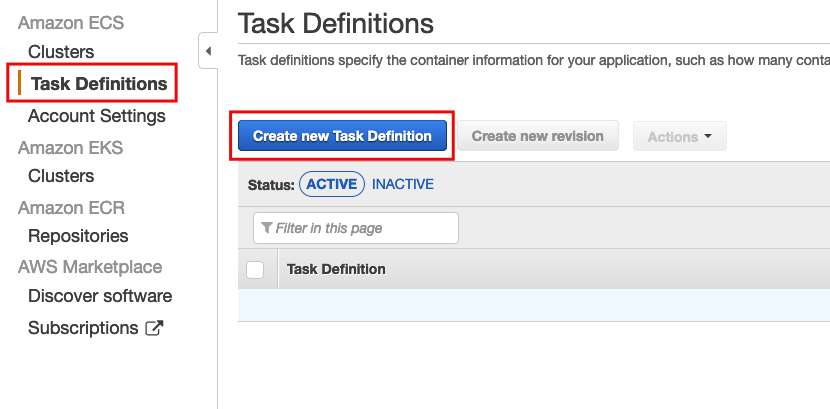

## 3. Select `Fargate` as your launch type compatibility and then select `Next step`

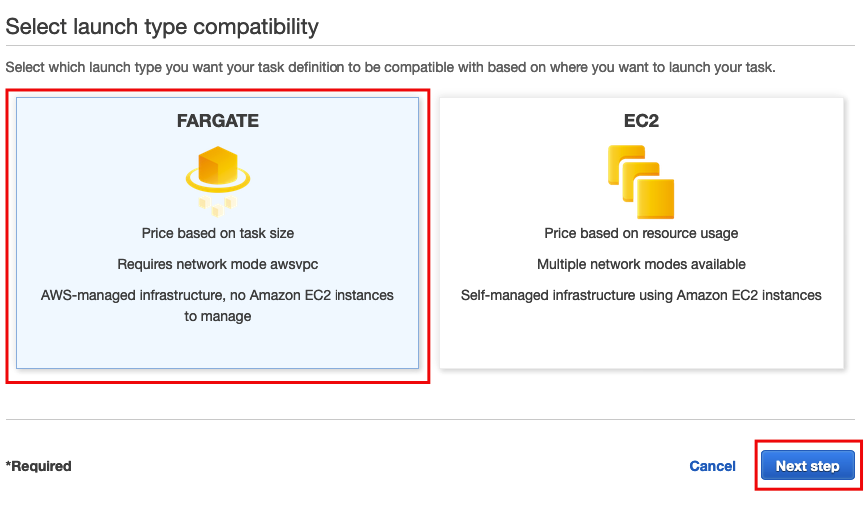

## 4. Enter `web_app_task` as the Task Definition Name
## 5. For Task Role, select `ecsTaskExecutionRole`
## 6. For Network Mode, confirm that `awsvpc` is selected   
## 7. For Task execution role, select `ecsTaskExecutionRole`

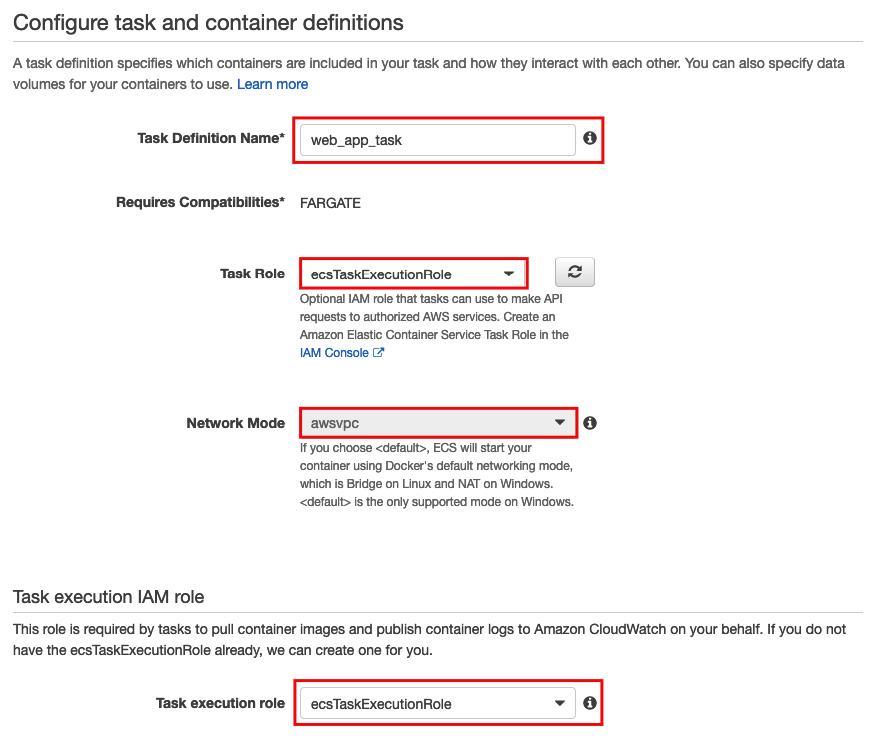


## 8. Under Task size, Select `2 GB` for Task Memory and select `1 vCPU` for Task CPU
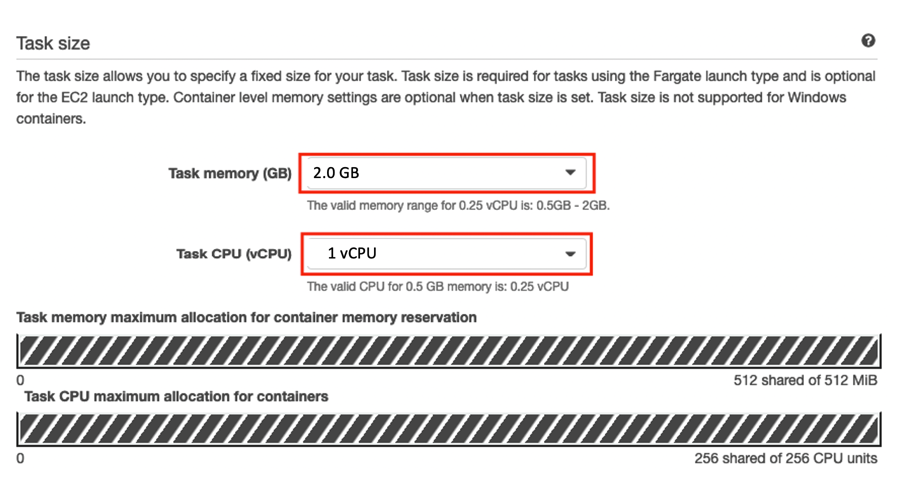

## 9. Then, Select `Add container`
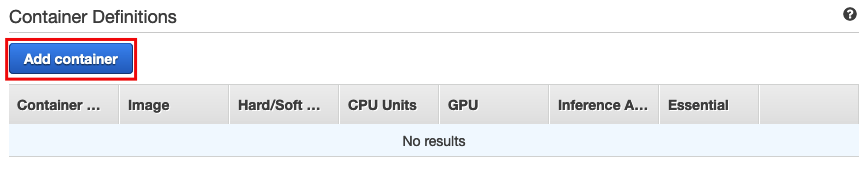

### 9a. For container name, call it `web_app_task`

### 9b. For Image, we need to find the Image URI for the image that we just created. You can find its URI by going [here](https://console.aws.amazon.com/ecr/repositories/) and selecting the repo named `web_app_sentence_relevance`. 

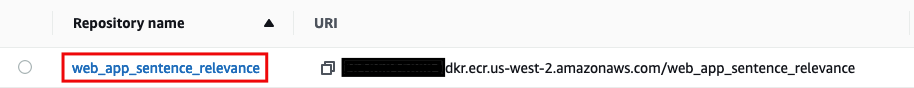

### 9c. Click the `Copy URI` button

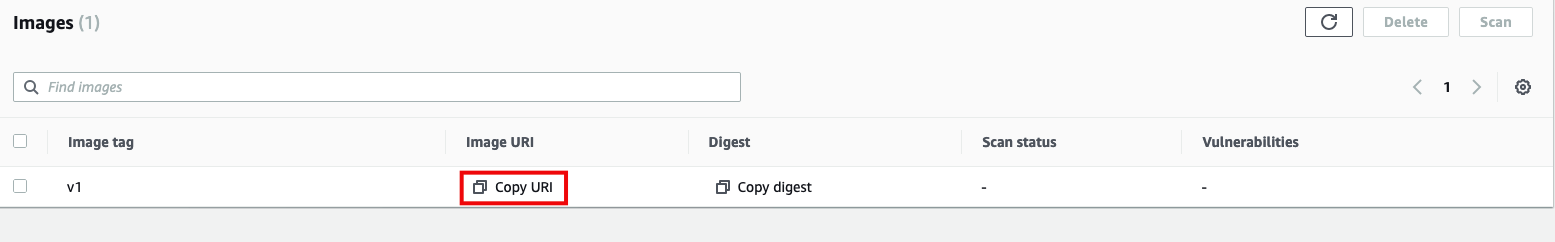

### 9d. Return back to the ECS tab and paste the Image URI into the text box for Image
NOTE: Make sure that the Image URI that you copied includes the version at the end. In our case, the version is v1 your Image URI should look something like this `xxxxxxxxxxxx.dkr.ecr.us-east-1.amazonaws.com/web_app_sentence_relevance:v1`


### 9e. Next, enter `8501` for Port Mappings
This port is selected because it is the default port for Streamlit

### 9f. Leave everything else with default values

### 9g. Click `Add`

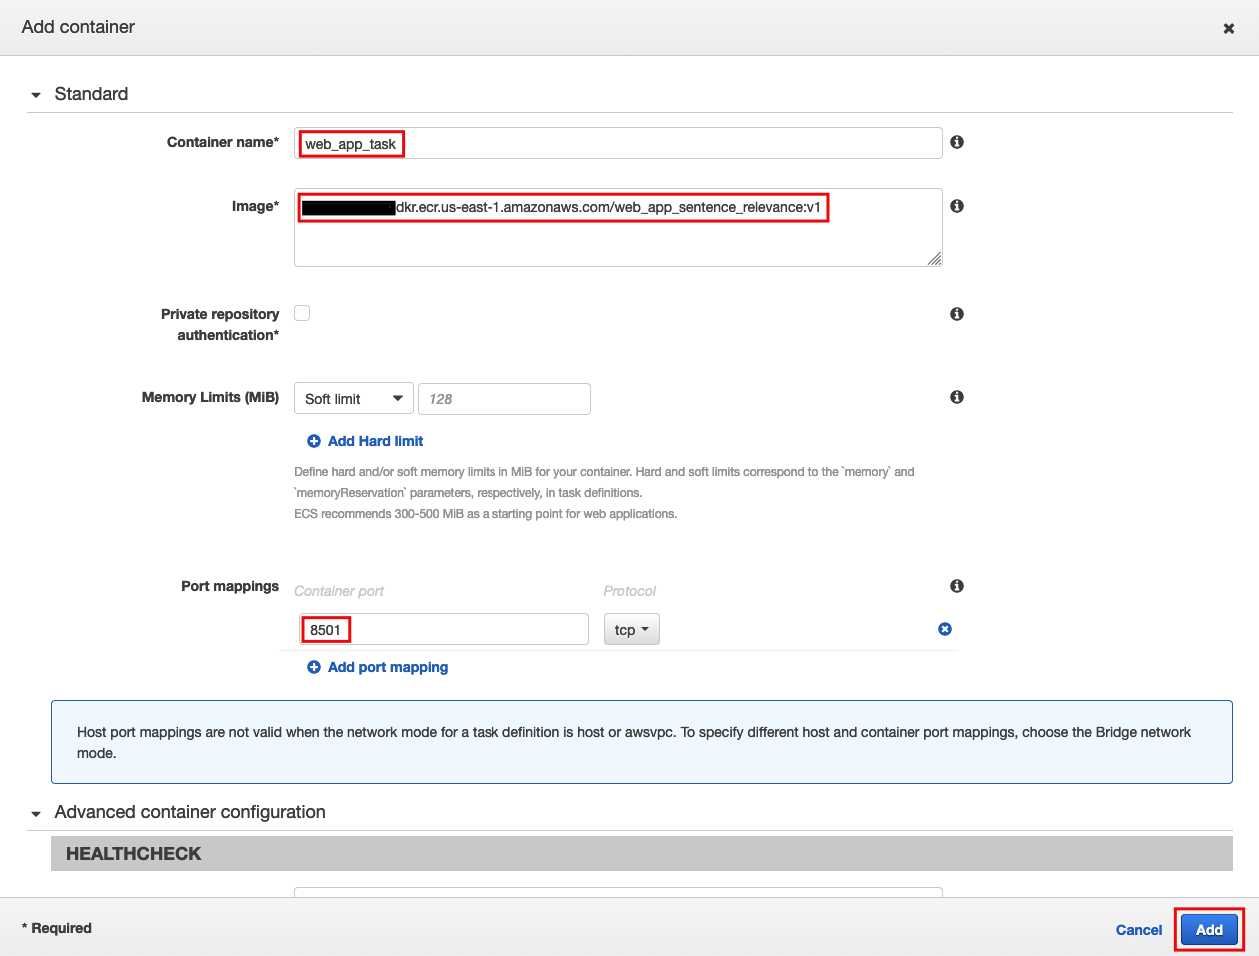

## 10. Scroll to the bottom and select `Create`
You may see a `Network Mode` displayed. You can ignore it and continue with the next step.

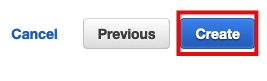

NOTE: For the purposes of this workshop, we will be deploying the model to a public subnet and assigning it a public IP address. This model is therefore accessible to anyone with an internet connection. In production, you should deploy your model to a private subnet. 

# Deploy the Container 

Now that we've created the container, our next step is to **deploy** the container. 

### 1. Go back to the main ECS Page by first clicking `View Task Definition` in the bottom right hand corner 

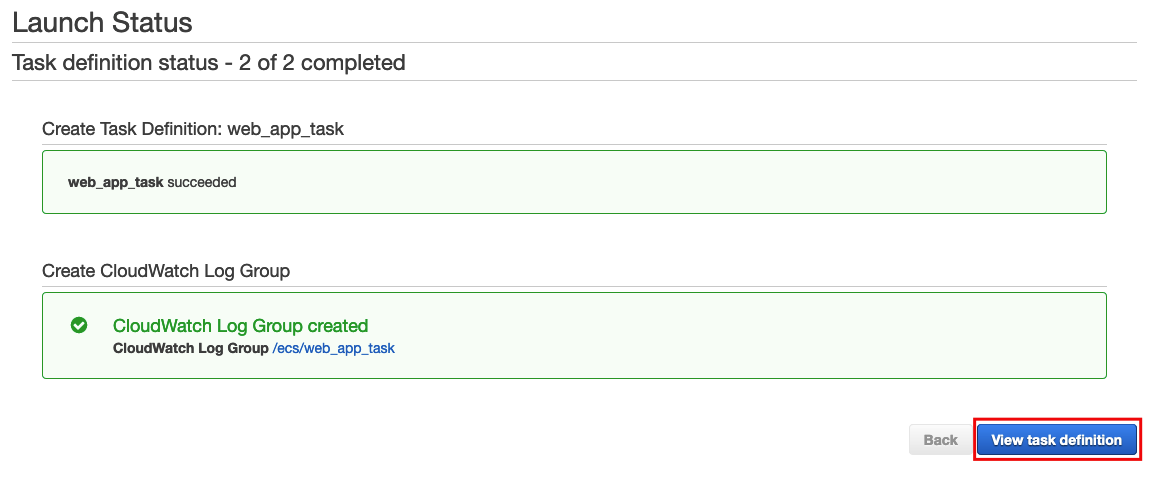

### 2. Then click the `Clusters` tab on the sidebar

### 3. Select `My-Container-Cluster`

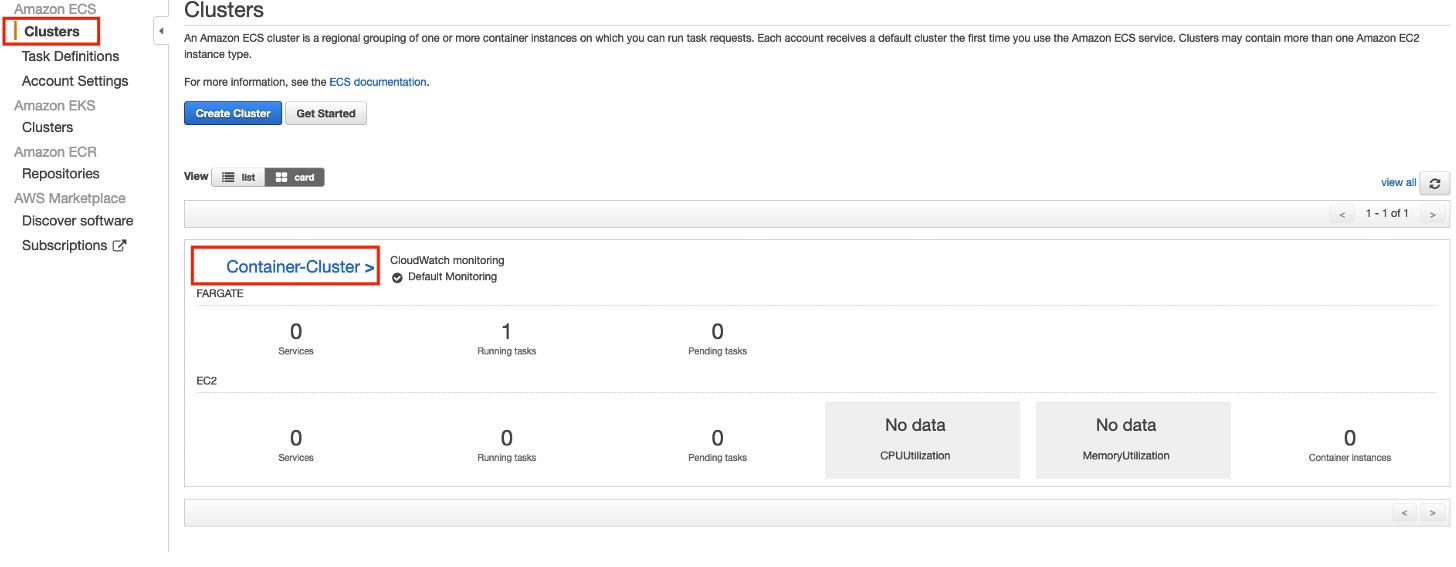

### 4. Then select the `Tasks` tab and click `Run new Task`

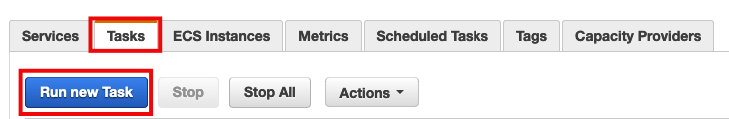

### 5. For the Launch type, choose `Fargate`

### 6. For Task Definition select `web_app_task`

### 7. For Cluster VPC, select the VPC that was created using the CloudFormation Template
NOTE: If you aren't sure which VPC to choose, hover your mouse over each VPC option and the entire VPC name will appear. Select the VPC that is named `sentence_relevance_VPC`

### 8. For Subnet, select the **Public Subnet** that was also created using the CloudFormation Template

### 9. For Security Groups, select `PublicAccess8501`

### 10. For auto-assign public IP, select `ENABLED`

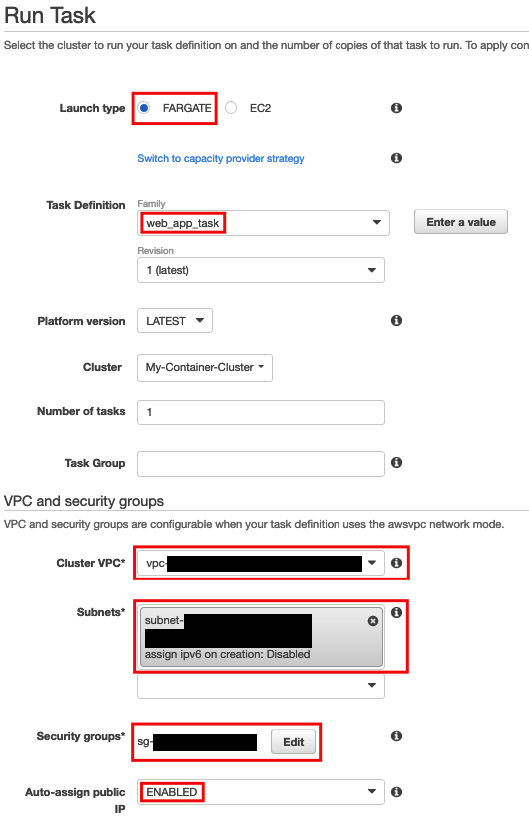

### 11. Leave everything else as default, scroll to the bottom, and click `Run Task` 
NOTE: It will take a few minutes to actually deploy and begin running

### 12. Once the container is deployed, select the `Task` to see the task's details

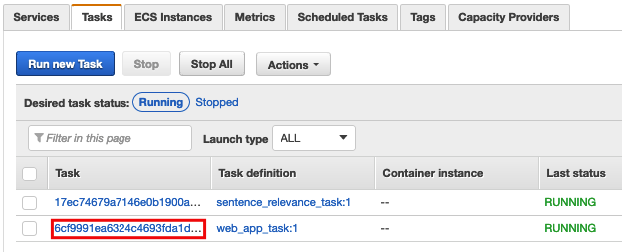

### 13. Copy the Public IP address

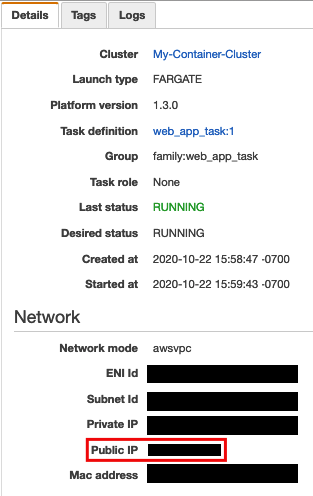

### 14. Open a new tab in your browser and type `{public_ip_address}:8501` 
You can also get the web address from the log tab of the container when it has entered the `Running` status.
This will take you to the deployed GUI.

# Testing Your Web App

You will be immediately prompted to login to the website upon loading the page. Use the password that you set above and press `Enter`

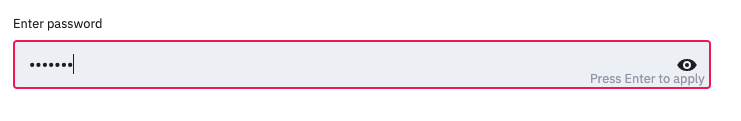

Once you enter in the password correctly, you will be brought to the home page that looks like this

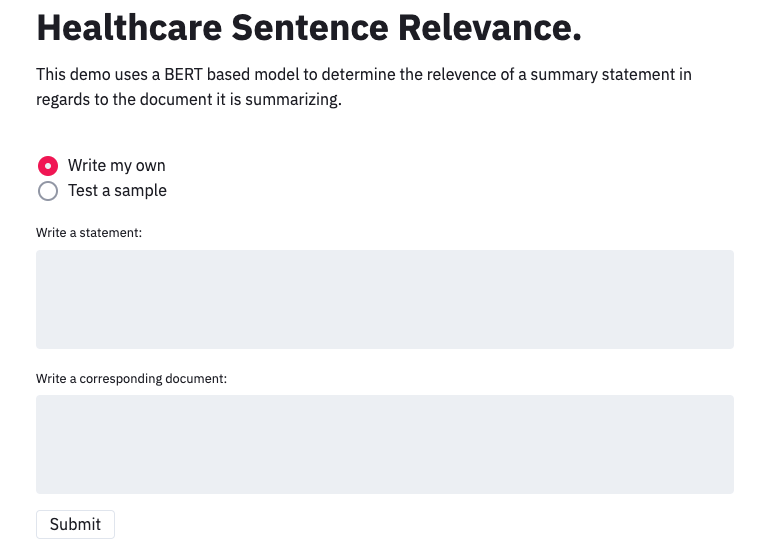

If you click the `About` button on the left-hand sidebar, you will be brought to the About page which will summarize the main purpose and features of this demo.

If you want to return to the home page, just select the `Demo` button on the left-hand sidebar.

To test out the demo, there are two options you can choose. If you have your own sample you would like to test, then you may select the `Write my own` option, and paste your own statement and corresponding document in the text boxes provided. 

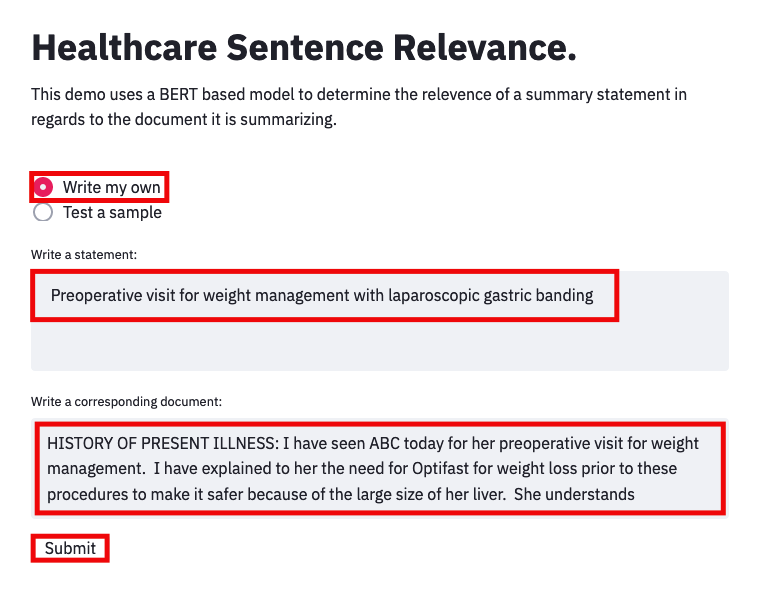

If you do not have your own sample and you just want to quickly test the demo, you can choose one of our preloaded samples to test. First, select `Test a sample`, and then choose a sample statement from the drop down menu. The corresponding document will auto-fill after you've selected your sample statement. 

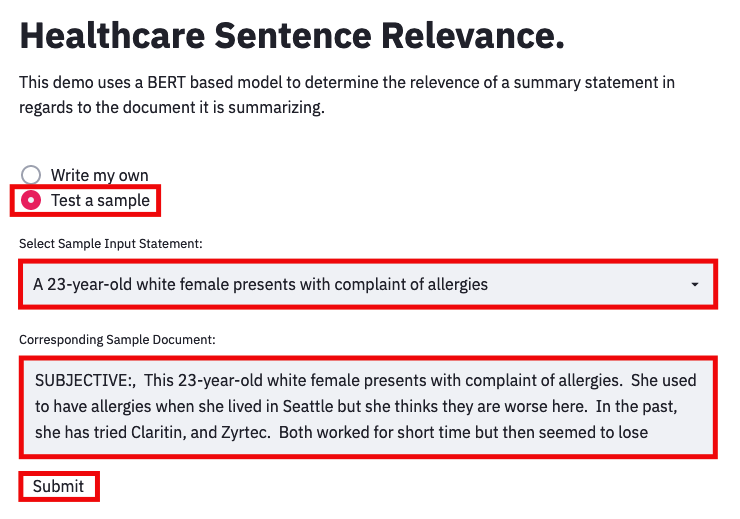

Once the statement and corresponding document fields are filled, click the submit button to run your model and get the sentence relevance results for your sample!

NOTE: Depending on the size of your sample & corresponding document, it might take a few minutes to get the results.

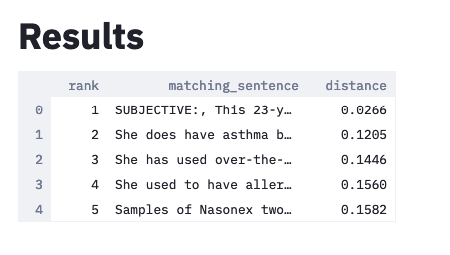

As you can see, in this sample, the model has successfully matched the description sentence with the closest sentence in the transcript (with a distance of .0266). This example is fairly simple; the description and the matching sentence are nearly identical. Feel free to try with harder, more complex examples.

# Cleanup
When you've finished with this solution, make sure that you delete all unwanted AWS resources. AWS CloudFormation can be used to automatically delete all standard resources that have been created by the solution and notebook. From the ECS Clusters, manually de-deploy the deployed containers by clicking the running tasks and selecting `Stop`. Next, Go to the AWS CloudFormation Console, and delete the `Medical_Text_Analysis` stack. Note that if you try to delete the stack prior to stopping the ECS cluster will **not** be deleted.

**Caution**: You need to still delete other resources manually created. From the AWS SageMaker Console, you can [delete the SageMaker Studio domain you created](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-studio-delete-domain.html). From the AWS ECR Console, you can manually delete the registered images.